# Flood model

We consider the test case of the overflow of a river:

$$S = \left(\frac{Q}{Ks\times300\times\sqrt{(Zm-Zv)/5000}}\right)^{(3/5) +Zv-55.5-3}$$

It is considered that failure occurs when the difference between the dike height and the water level is positive:

$$S > 0 $$

Four independent random variables are considered:

 - Q (Flow rate) [m^3 s^-1]
 - Ks (Strickler) [m^1/3 s^-1]
 - Zv (downstream height) # [m]
 - Zm (upstream height) # [m]

Stochastic model:

 - Q ~ Gumbel(alpha=0.00179211, beta=1013), Q > 0
 - Ks ~ Normal(mu=30.0, sigma=7.5), Ks > 0
 - Zv ~ Uniform(a=49, b=51)
 - Zm ~ Uniform(a=54, b=56)


In [52]:
from __future__ import print_function
import openturns as ot

In [53]:
# Create the marginal distributions of the parameters
dist_Q = ot.TruncatedDistribution(ot.Gumbel(1./558., 1013.), 0, ot.TruncatedDistribution.LOWER)
dist_Ks = ot.TruncatedDistribution(ot.Normal(30.0, 7.5), 0, ot.TruncatedDistribution.LOWER)
dist_Zv = ot.Uniform(49.0, 51.0)
dist_Zm = ot.Uniform(54.0, 56.0)
marginals = [dist_Q, dist_Ks, dist_Zv, dist_Zm]

In [54]:
# Create the Copula
RS = ot.CorrelationMatrix(4)
#RS[2, 3] = -0.2
# Evaluate the correlation matrix of the Normal copula from RS
R = ot.NormalCopula.GetCorrelationFromSpearmanCorrelation(RS)
# Create the Normal copula parametrized by R
copula = ot.NormalCopula(R) 

In [55]:
# Create the joint probability distribution
distribution = ot.ComposedDistribution(marginals, copula)
distribution.setDescription(['Q', 'Ks', 'Zv', 'Zm'])

In [62]:
# create the model
model = ot.SymbolicFunction(['Q', 'Ks', 'Zv', 'Zm'],
                            ['(Q/(Ks*300.*sqrt((Zm-Zv)/5000)))^(3.0/5.0)+Zv-55.5-3.'])

In [57]:
# create the event we want to estimate the probability
vect = ot.RandomVector(distribution)
G = ot.CompositeRandomVector(model, vect)
event = ot.Event(G, ot.Greater(), 0.0)
event.setName('overflow')

In [58]:
# Define a solver
optimAlgo = ot.Cobyla()
optimAlgo.setMaximumEvaluationNumber(1000)
optimAlgo.setMaximumAbsoluteError(1.0e-10)
optimAlgo.setMaximumRelativeError(1.0e-10)
optimAlgo.setMaximumResidualError(1.0e-10)
optimAlgo.setMaximumConstraintError(1.0e-10)

In [59]:
# Run FORM
startingPoint = distribution.getMean()
algo = ot.FORM(optimAlgo, event, startingPoint)
algo.run()
result = algo.getResult()
standardSpaceDesignPoint = result.getStandardSpaceDesignPoint()

In [60]:
# retrieve results
result = algo.getResult()
probability = result.getEventProbability()
print('Pf=', probability)

Pf= 0.0005340887806480156


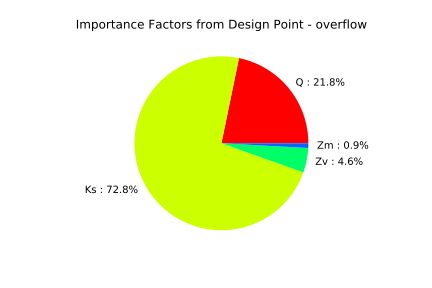

In [61]:
# Importance factors
result.drawImportanceFactors()